# Homework 10
## Deep Learning Technologies
### Shruti Badrinarayanan - 016768141

[Github Link](https://github.com/shruti-badri-14/Deep-Learning-Homework/tree/main/Assignment%2010)

In [ ]:
# !pip install transformers[torch] datasets torch accelerate

In [ ]:
# pip install 'portalocker>=2.0.0'

# Load Data

In [ ]:
from torchtext.datasets import SQuAD2
from datasets import load_dataset

# Load the SQuAD 2.0 dataset
dataset = load_dataset("squad_v2")

# Take a subset of 200 QnA pairs for train, 25 for val, and 25 for test
small_train_dataset = dataset['train'].select(range(240))
val_dataset = dataset['train'].select(range(240, 270))
inference_dataset = dataset['train'].select(range(270, 300))

# Raw QnA Data Samples

In [ ]:
for i, example in enumerate(small_train_dataset):
    print(f"QnA pair {i+1}")
    print("Question:", example['question'])
    print("Context:", example['context'])
    print("Answers:", example['answers']['text'])
    print("\n")
    if i == 4:  # Display 5 examples
        break

QnA pair 1
Question: When did Beyonce start becoming popular?
Context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Answers: ['in the late 1990s']


QnA pair 2
Question: What areas did Beyonce compete in when she was growing up?
Context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwr

# Prepare Data (Preprocessing)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def preprocess_examples(examples, tokenizer, max_length=512):
    inputs = tokenizer(
        examples['question'],
        examples['context'],
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
        return_offsets_mapping=True
    )
    offsets = inputs.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offset in enumerate(offsets):
        # Check if 'answers' is not empty and has required keys
        if examples['answers'] and 'answer_start' in examples['answers'][i] and 'text' in examples['answers'][i]:
            answer = examples['answers'][i]
            # Check if there's at least one answer
            if answer['answer_start'] and answer['text']:
                start_char = answer['answer_start'][0]
                end_char = start_char + len(answer['text'][0])
                start_positions.append(
                    next((idx for idx, off in enumerate(offset) if off[0] <= start_char < off[1]), 0)
                )
                end_positions.append(
                    next((idx for idx, off in enumerate(offset) if off[0] < end_char <= off[1]), 0)
                )
            else:
                # Default to 0 if there's no answer
                start_positions.append(0)
                end_positions.append(0)
        else:
            # Default to 0 if 'answers' is empty
            start_positions.append(0)
            end_positions.append(0)

    inputs['start_positions'] = torch.tensor(start_positions)
    inputs['end_positions'] = torch.tensor(end_positions)
    return inputs

# Processing datasets
train_encodings = preprocess_examples(small_train_dataset, tokenizer)
val_encodings = preprocess_examples(val_dataset, tokenizer)

# Create DataLoaders
train_dataset = TensorDataset(
    train_encodings['input_ids'], train_encodings['attention_mask'],
    train_encodings['start_positions'], train_encodings['end_positions']
)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataset = TensorDataset(
    val_encodings['input_ids'], val_encodings['attention_mask'],
    val_encodings['start_positions'], val_encodings['end_positions']
)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

# Training

In [ ]:
from transformers import BertForQuestionAnswering

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
model.to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

# Setup the learning rate scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm import tqdm

num_epochs = 20

training_losses = []
validation_losses = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = tuple(item.to(device) for item in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'start_positions': batch[2],
            'end_positions': batch[3]
        }
        optimizer.zero_grad()

        outputs = model(**inputs)
        loss = outputs[0]

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    total_eval_loss = 0
    for batch in val_loader:
        batch = tuple(item.to(device) for item in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'start_positions': batch[2],
            'end_positions': batch[3]
        }

        with torch.no_grad():
            outputs = model(**inputs)
            loss = outputs[0]
            total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(val_loader)
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} | Validation Loss: {avg_val_loss:.4f}")
    model.train()

100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


Epoch 1 | Train Loss: 4.7649
Epoch 1 | Validation Loss: 3.8886


100%|██████████| 24/24 [00:22<00:00,  1.07it/s]


Epoch 2 | Train Loss: 3.3845
Epoch 2 | Validation Loss: 3.7027


100%|██████████| 24/24 [00:22<00:00,  1.07it/s]


Epoch 3 | Train Loss: 2.6237
Epoch 3 | Validation Loss: 3.1791


100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


Epoch 4 | Train Loss: 1.8418
Epoch 4 | Validation Loss: 3.0622


100%|██████████| 24/24 [00:23<00:00,  1.02it/s]


Epoch 5 | Train Loss: 1.2757
Epoch 5 | Validation Loss: 2.7593


100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Epoch 6 | Train Loss: 0.9009
Epoch 6 | Validation Loss: 3.0512


100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Epoch 7 | Train Loss: 0.6193
Epoch 7 | Validation Loss: 2.8252


100%|██████████| 24/24 [00:24<00:00,  1.00s/it]


Epoch 8 | Train Loss: 0.4614
Epoch 8 | Validation Loss: 2.9466


100%|██████████| 24/24 [00:23<00:00,  1.00it/s]


Epoch 9 | Train Loss: 0.3843
Epoch 9 | Validation Loss: 3.0501


100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Epoch 10 | Train Loss: 0.2891
Epoch 10 | Validation Loss: 3.0615


100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Epoch 11 | Train Loss: 0.2324
Epoch 11 | Validation Loss: 3.0903


100%|██████████| 24/24 [00:23<00:00,  1.00it/s]


Epoch 12 | Train Loss: 0.1845
Epoch 12 | Validation Loss: 3.3167


100%|██████████| 24/24 [00:24<00:00,  1.00s/it]


Epoch 13 | Train Loss: 0.1786
Epoch 13 | Validation Loss: 3.8180


100%|██████████| 24/24 [00:24<00:00,  1.00s/it]


Epoch 14 | Train Loss: 0.1573
Epoch 14 | Validation Loss: 3.3390


100%|██████████| 24/24 [00:24<00:00,  1.00s/it]


Epoch 15 | Train Loss: 0.1659
Epoch 15 | Validation Loss: 3.1858


100%|██████████| 24/24 [00:23<00:00,  1.00it/s]


Epoch 16 | Train Loss: 0.1929
Epoch 16 | Validation Loss: 3.2480


100%|██████████| 24/24 [00:23<00:00,  1.00it/s]


Epoch 17 | Train Loss: 0.1064
Epoch 17 | Validation Loss: 3.2494


100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Epoch 18 | Train Loss: 0.1000
Epoch 18 | Validation Loss: 3.4453


100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Epoch 19 | Train Loss: 0.0819
Epoch 19 | Validation Loss: 3.2665


100%|██████████| 24/24 [00:23<00:00,  1.00it/s]


Epoch 20 | Train Loss: 0.0417
Epoch 20 | Validation Loss: 3.7830


# Evaluation

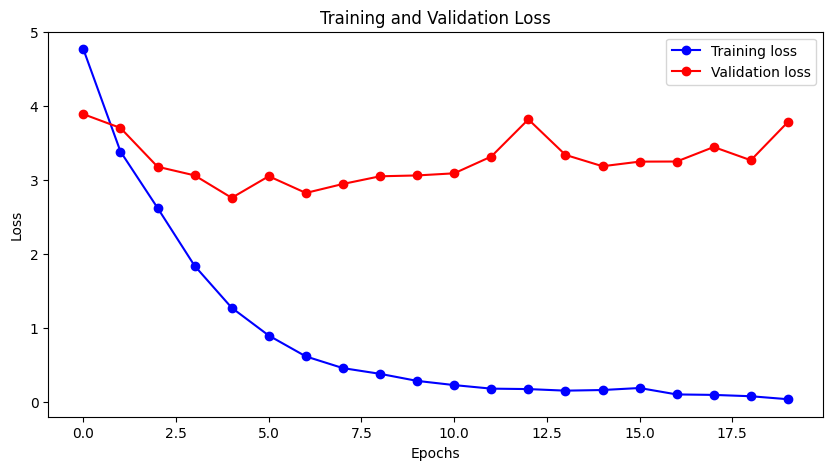

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
epochs = range(len(training_losses))
plt.figure(figsize=(10,5))
plt.plot(epochs, training_losses, 'b-o', label='Training loss')
plt.plot(epochs, validation_losses, 'r-o', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation

In [29]:
from transformers import pipeline
from collections import Counter
import string
import re
import numpy as np

def normalize_answer(s):
    """Lower text and remove punctuation, articles, and extra whitespace."""
    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punct(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_punct(lower(s)))

def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common_tokens = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common_tokens.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

model.eval()
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

em_score = 0
f1_score_total = 0
for example in inference_dataset:
    question = example["question"]
    context = example["context"]
    answers = example["answers"]
    ground_truth = answers['text'][0] if answers['text'] else "No answer"

    # Use the pipeline to make a prediction
    prediction = qa_pipeline({'question': question, 'context': context})
    predicted_answer = prediction['answer']

    # Calculate and accumulate scores
    em_score += exact_match_score(predicted_answer, ground_truth)
    f1_score_total += f1_score(predicted_answer, ground_truth)

# Calculate average scores and print them
avg_em_score = em_score / len(inference_dataset)
avg_f1_score = f1_score_total / len(inference_dataset)
print(f"Average Exact Match (EM) Score: {avg_em_score:.2f}")
print(f"Average F1 Score: {avg_f1_score:.2f}")

Average Exact Match (EM) Score: 0.37
Average F1 Score: 0.50


# Inference

In [ ]:
from transformers import pipeline

model.eval()

qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

for example in inference_dataset:
    question = example["question"]
    context = example["context"]
    answers = example["answers"]
    ground_truth = answers['text'][0] if answers['text'] else "No answer"

    prediction = qa_pipeline({'question': question, 'context': context})
    print(f"Question: {question}")
    print(f"Predicted Answer: {prediction['answer']}")
    print(f"Ground Truth Answer: {ground_truth}")
    print("\n-----\n")

Question: How many Tweets per minute did the half time show get?
Predicted Answer: 268,000
Ground Truth Answer: 268,000 tweets per minute

-----

Question: When did Destiny's Child release Love Songs?
Predicted Answer: 2013
Ground Truth Answer: January 2013

-----

Question: What was the new track for Love Songs?
Predicted Answer: Nuclear".
Ground Truth Answer: Nuclear

-----

Question: What did Beyoncé sing at President Obama's second inauguration?
Predicted Answer: Washington, D.C.
Ground Truth Answer: the American national anthem

-----

Question: What event did Beyoncé perform at one month after Obama's inauguration? 
Predicted Answer: Super Bowl XLVII halftime show
Ground Truth Answer: Super Bowl XLVII halftime show

-----

Question: What is the name of Beyoncé's documentary film?
Predicted Answer: President Obama's second inauguration in Washington, D.C.
Ground Truth Answer: Life Is But a Dream

-----

Question: How many dates did Beyonce's "The Mrs. Carter Show" entail?
Predicte

### Conclusion: As seen, there are some accurately predicted answers and some are partially correct. The model seems to perform moderately well.